In [1]:
# https://drive.google.com/file/d/1c0irqiDFwTvhEq845ZLQCqo6cvW_JNfL/view?usp=sharing
import gdown
file_id = '1c0irqiDFwTvhEq845ZLQCqo6cvW_JNfL'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'data.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1c0irqiDFwTvhEq845ZLQCqo6cvW_JNfL
To: /content/data.zip
100%|██████████| 13.9M/13.9M [00:00<00:00, 29.7MB/s]


'data.zip'

In [2]:
!unzip data.zip

Archive:  data.zip
   creating: sales_predit/
  inflating: sales_predit/items.csv  
  inflating: sales_predit/item_categories.csv  
  inflating: sales_predit/sales_train.csv  
  inflating: sales_predit/shops.csv  


In [6]:
import pandas as pd
sales_train = pd.read_csv('/content/sales_predit/sales_train.csv')
item_categories = pd.read_csv('/content/sales_predit/item_categories.csv')
items = pd.read_csv('/content/sales_predit/items.csv')
shops = pd.read_csv('/content/sales_predit/shops.csv')

In [4]:
# 회귀, RMSE
# 데이터 병합(여러개존재하는 경우) ,그룹화
# 피처명 한글화, 다운캐스팅, 조합, 이어붙이고, 병합, 이상치 제거, 파생피처 생성
# 회귀 : 특정 피처를 기준으로 그룹화해서 값을 집계하는 일이 많다.
# 이상치여부 확인하고 대처
# 피처생성 : 두개이상의 피처를 조합
# 시계열 데이터 : 시차 피처(과거 시점에 대한 피처)

In [10]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [24]:
# 월별 판매량
sales_train_copy = sales_train.copy()

# sales_train_copy['month'] = pd.to_datetime(sales_train_copy['date'],
#                                            format='%d.%m.%Y').dt.month

# 'date_block_num' --> 년도별 월을 라벨인코딩과 같이 범주형으로되어 있음
# date를 삭제함
sales_train_copy.drop('date', axis=1, inplace=True)
sales_train_copy.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.00,1.0
1,0,25,2552,899.00,1.0
2,0,25,2552,899.00,-1.0
3,0,25,2554,1709.05,1.0
4,0,25,2555,1099.00,1.0


In [26]:
# 월간 판매량
grouped = sales_train_copy.groupby('date_block_num')
item_count_day_sum = grouped['item_cnt_day'].sum()

In [27]:
sales_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int64  
 1   shop_id         int64  
 2   item_id         int64  
 3   item_price      float64
 4   item_cnt_day    float64
dtypes: float64(2), int64(3)
memory usage: 112.0 MB


In [28]:
# ~ 2015/9월  train
# .... valid
item_count_day_sum.shape

(34,)

In [34]:
# 데이터 병합
# sales_train_copy shops
train = pd.merge(sales_train_copy, shops, on='shop_id', how='left')
train = pd.merge(train, items, on='item_id', how='left')
train = pd.merge(train, item_categories, on='item_category_id', how='left')

In [35]:
train.head(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,25,2552,899.0,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил


In [41]:
summary = pd.DataFrame(train.dtypes,columns=['데이터 타입'])
summary['결측값 개수'] = train.isnull().sum()
summary['고유값'] = train.nunique()
summary['첫 번째 값'] = train.iloc[0]
summary['두번째 값'] = train.iloc[1]
summary

,데이터 타입,결측값 개수,고유값,첫 번째 값,두번째 값
date_block_num,int64,0,34,0,0
shop_id,int64,0,60,59,25
item_id,int64,0,21807,22154,2552
item_price,float64,0,19993,999.0,899.0
item_cnt_day,float64,0,198,1.0,1.0
shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
item_category_id,int64,0,84,37,58
item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


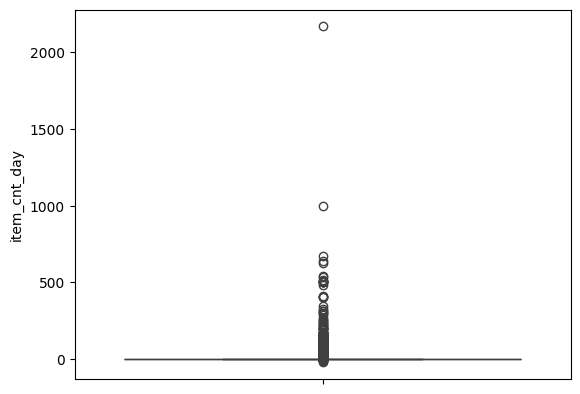

In [43]:
# 데이터 시각 item_cnt_day
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.boxplot(data=train, y = 'item_cnt_day')
plt.show()
#일별 판매량


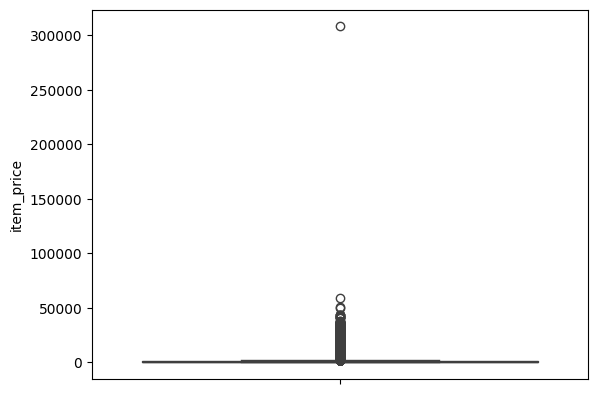

In [45]:
#판매량
sns.boxplot(data=train, y = 'item_price')
plt.show()
# 5000이상 제거

In [47]:
group = train.groupby('date_block_num')
group = group['item_price'].sum()
group.reset_index()

,date_block_num,item_price
0,0,8.221187e+07
1,1,7.558019e+07
2,2,8.429831e+07
3,3,6.151282e+07
4,4,5.727413e+07
5,5,6.334361e+07
6,6,6.219681e+07
7,7,6.543817e+07
8,8,7.270157e+07
9,9,7.391497e+07


In [52]:
group = group.reset_index()

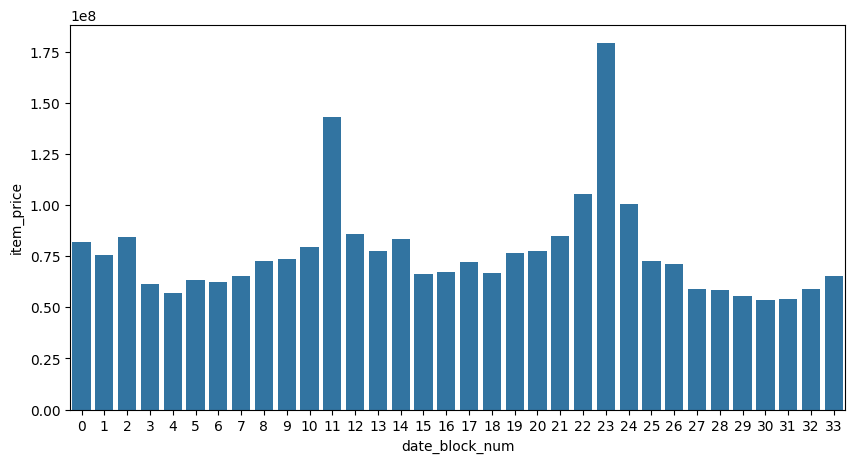

In [53]:
# 월별 판매량
plt.figure(figsize=(10,5))
sns.barplot(data=group, x='date_block_num', y='item_price')
plt.show()

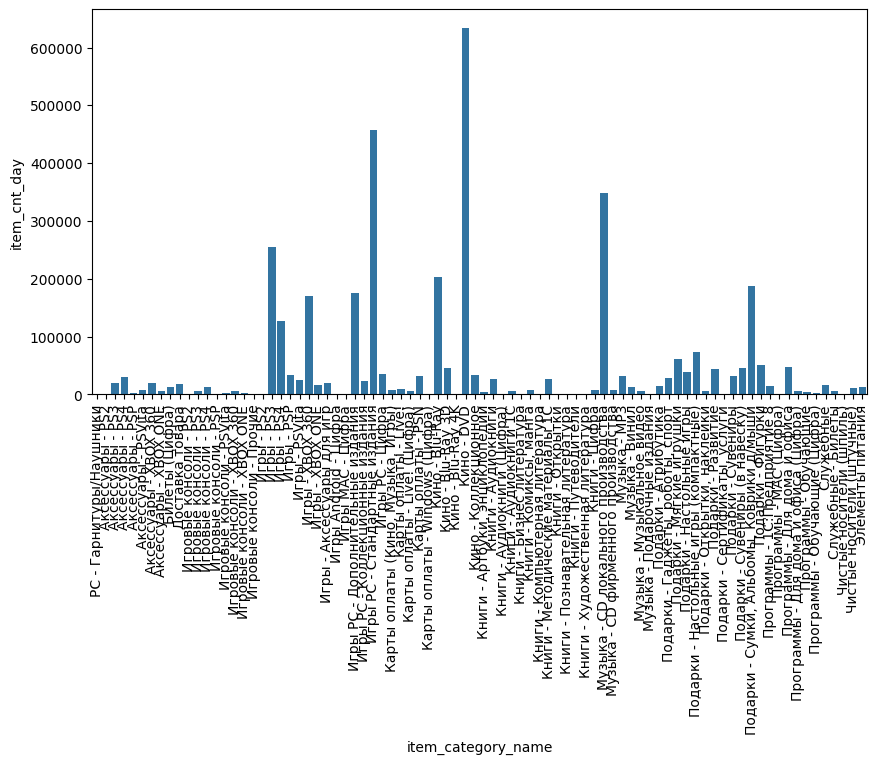

In [58]:
# 상품분류별 총 상품 판매량
group = train.groupby('item_category_name')
group = group['item_cnt_day'].sum()
group = group.reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=group, x='item_category_name', y='item_cnt_day')
plt.xticks(rotation=90)
plt.show()


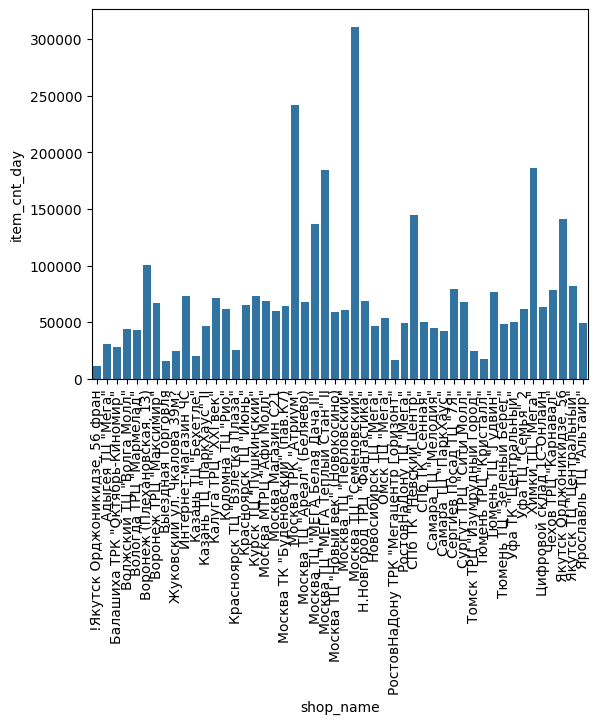

In [62]:
# 상점별 판매량 : 월간판매량이 10000개 초과인 상품분류만 추출

# 상점별 총 상품 판매량
group = train.groupby('shop_name')
group = group['item_cnt_day'].sum()
group = group.reset_index()
group = group[group['item_cnt_day'] > 10000]
sns.barplot(data=group, x='shop_name', y='item_cnt_day')
plt.xticks(rotation=90)
plt.show()


- 시계열데이터 : 순서지키기(검증데이터는 최근 1개월)
- 타깃값 : 월별 판매량
- 데이터 병합
- 피처제거 : date, 상점id 삼품id 상품분류id - 각각 이름 이중에 하나만 사용
- 이상치 제거 : 일별 판매량, 월별판매량


# 모델

In [167]:
import pandas as pd
sales_train = pd.read_csv('/content/sales_predit/sales_train.csv')
item_categories = pd.read_csv('/content/sales_predit/item_categories.csv')
items = pd.read_csv('/content/sales_predit/items.csv')
shops = pd.read_csv('/content/sales_predit/shops.csv')

In [168]:
sales_train = sales_train.rename(columns={'date':'날자','date_block_num':'월id','shop_id':'상점id','item_id':'상품id','item_price':'가격','item_cnt_day':'일별판매량'},
                   )

In [169]:
shops = shops.rename(columns={'shop_name':'상점이름','shop_id':'상점id'})

In [170]:
items = items.rename(columns={'item_name':'상품이름','item_id':'상품id','item_category_id':'상품분류id'})

In [171]:
item_categories = item_categories.rename(columns={'item_category_name':'상품분류이름','item_category_id':'상품분류id'})

In [172]:
# 메모리 사용량이 많은거 같아서 다운캐스팅
def downcast(df, verbose=True):
  start_mem = df.memory_usage().sum() / 1024**2    # 바이트 단위로
  for col in df.columns:
    dtype_name = df[col].dtype.name
    if dtype_name == 'object':
      pass
    elif dtype_name == 'bool':
      df[col] = df[col].astype('int8')
    elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():   # 2.0
      df[col] = pd.to_numeric(df[col], downcast='integer')
    else:
      df[col] = pd.to_numeric(df[col], downcast='float')
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose:
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

In [173]:
all_df = [sales_train, shops, items, item_categories]
for df in all_df:
  downcast(df)

Mem. usage decreased to 61.60 Mb (54.2% reduction)
Mem. usage decreased to  0.00 Mb (38.6% reduction)
Mem. usage decreased to  0.23 Mb (54.2% reduction)
Mem. usage decreased to  0.00 Mb (39.9% reduction)


In [174]:
sales_train

,날자,월id,상점id,상품id,가격,일별판매량
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1
2935845,09.10.2015,33,25,7460,299.00,1
2935846,14.10.2015,33,25,7459,349.00,1
2935847,22.10.2015,33,25,7440,299.00,1


In [175]:
# 월ID 상점ID 상품ID
from itertools import product
import numpy as np
train = []
# 월id 상점id 상품id 조합 생성
for i in sales_train['월id'].unique():
  shop_ids = sales_train.loc[sales_train['월id'] == i, '상점id'].unique()
  item_ids = sales_train.loc[sales_train['월id'] == i, '상품id'].unique()
  train.append(np.array(list(product([i], shop_ids, item_ids)), dtype='int32'))
train  = pd.DataFrame(np.vstack(train), columns=['월id', '상점id', '상품id'])
train

,월id,상점id,상품id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


In [176]:
# 월간 판매량 추가
group = sales_train.groupby(['월id', '상점id', '상품id'])['일별판매량'].sum().reset_index()
group.rename(columns={'일별판매량':'월간판매량'}, inplace=True)
train = pd.merge(train, group, on=['월id', '상점id', '상품id'], how='left')

In [177]:
# 가비지 컬럭테 ( 메모리정리 )
import gc
del group # 더이상 사용하지 않는 변수
gc.collect()

16211

In [178]:
train.fillna(0, inplace=True)

In [179]:
train

,월id,상점id,상품id,월간판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
10913845,33,21,7635,0.0
10913846,33,21,7638,0.0
10913847,33,21,7640,0.0
10913848,33,21,7632,0.0


In [ ]:
train = train.merge(shops, on='상점id', how='left')
train = train.merge(items, on='상품id', how='left')
train = train.merge(item_categories, on='상품분류id', how='left')
#다운 캐스팅
all_data = downcast(train)
#가비지컬렉터
del shops, items, item_categories
gc.collect()

In [ ]:
train.drop(['상점이름', '상품이름', '상품분류이름'], axis=1, inplace=True)

In [ ]:
train['월id'].unique()

In [ ]:
x_train = train.loc[train['월id'] < 32].drop(['월간판매량'], axis=1)
x_val = train.loc[train['월id'] == 32].drop(['월간판매량'], axis=1)
x_test = train.loc[train['월id'] == 33].drop(['월간판매량'], axis=1)

y_train = train.loc[train['월id'] < 32, '월간판매량']
# y_train 타깃값을 제한
y_train = y_train.clip(0, 100)

y_val = train.loc[train['월id'] == 32, '월간판매량']
y_val = y_train.clip(0, 100)

y_test = train.loc[train['월id'] == 33, '월간판매량']
y_test = y_train.clip(0, 100)

In [ ]:
del train
gc.collect()

In [ ]:
# 정답의 범위를 제한  판매량이 실제로 특정범위에서 발행하는 경우가 많다고 가정한다면
# 지나치게 크거나 작은값을 방지하기 위해서 범위를 제한하는 경우가 유리